In [2]:
import os, re
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 22

from csw_sims import *
from csw_analysis import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

## read sql database

In [3]:
dataset_dict = {
  "uncond_simpRFC_L":["exp_0330083713","exp_0403124119"],
  "uncond_simpRFC":"exp_0403124119",
  "subjcond_simpRFC":"exp_0406085953",
  "subjcond_subjvictRFC":"exp_0424112926",
  "uncond_half-full-rich":"exp_0501071312",
  "cond_half-full-rich":"exp_0503110822"
}

In [4]:
# sliding window
def mov_avg(arr,window):
  """ calculates with sliding window average on array
  """
  L = []
  for idx in range(len(arr)-window):
    score = sum(arr[idx:idx+window])/window
    L.append(score)
  return np.array(L)

# CEMS poster

In [5]:
def apply_fillerq_thresh(subj_df_L,subj_tqdf_L,subj_fqdf_L,thresh):
  """ makes subj_df_Ls with only subjects above thresh
  """
  subj_df_L_new = []
  subj_tqdf_L_new = []
  subj_fqdf_L_new = []
  for subj_df,subj_tqdf,subj_fqdf in zip(subj_df_L,subj_tqdf_L,subj_fqdf_L):
    fillerQ_score = sum(subj_fqdf['correct_response'])/subj_fqdf.shape[0]
    if fillerQ_score < thresh: continue
    subj_df_L_new.append(subj_df)
    subj_tqdf_L_new.append(subj_tqdf)
    subj_fqdf_L_new.append(subj_fqdf)
  print(len(subj_fqdf_L_new),'above thresh')
  return subj_df_L_new, subj_tqdf_L_new, subj_fqdf_L_new

def get_all_subj_df_Ls(dataset_name,filler_thresh):
  # load sql
  exp_dir = "mturk_data/"+dataset_dict[dataset_name]
  sql_df = get_sql_df(exp_dir)
  # make subj_df
  subj_df_L = []
  for s in range(len(sql_df)):
    psiturk_dstr = sql_df['datastring'].iloc[s] 
    subj_df = make_subj_df(psiturk_dstr)
    subj_df_L.append(subj_df)
  # assign expr
  for subj_df in subj_df_L:
    assign_expr(subj_df,conditioned=True)
  # question dfs with question subtypes
  subj_qdf_L = [subj_df[subj_df['type']=='question'] for subj_df in subj_df_L]
  subj_fqdf_L = [subj_df[subj_df['qtype'] == 'fillerQ'] for subj_df in subj_df_L]
  subj_tqdf_L = [subj_df[subj_df['qtype'] == 'transQ'] for subj_df in subj_df_L]
  # threshold filler questions
  subj_df_L,subj_tqdf_L,subj_fqdf_L = apply_fillerq_thresh(subj_df_L,
                                        subj_tqdf_L, subj_fqdf_L, filler_thresh)
  return subj_df_L,subj_tqdf_L,subj_fqdf_L


In [6]:
def get_common_denom(subj_score_L):
  """ given a list of lists, find smallest length"""
  len_L = [len(score) for score in subj_score_L]
  len_L.sort()
  min_len = len_L[0]
  return min_len
  
def compute_scores(subj_tqdf_L,window):
  """ given list of transition question dfs
  computes score and expr """
  subj_scores_L = []
  subj_expr_L = []
  for subj_tqdf in subj_tqdf_L:
    # compute and collect subj score and expr
    subj_score = mov_avg(subj_tqdf['correct_response'],window)
    subj_expr = mov_avg(subj_tqdf['expr_true_edge'],window)
    subj_scores_L.append(subj_score)
    subj_expr_L.append(subj_expr)
  return subj_scores_L, subj_expr_L

def group_mean_std_score(mov_avg_L):
  """ takes list of scores, returns group means
  after moving average has been applied
  get common smallest length and take group mean """
  # common denom
  min_len = get_common_denom(mov_avg_L)
  mov_avg_L = [subj_score[:min_len] for subj_score in mov_avg_L]
  # mean and stderr
  mean = np.mean(mov_avg_L,0)
  stderr = np.std(mov_avg_L,0) / np.sqrt(len(mov_avg_L))
  return mean,stderr

def full_plt_preproc(subj_tqdf_L,window):
  subj_scores_L, subj_expr_L = compute_scores(subj_tqdf_L,window)
  mean_score,std_score = group_mean_std_score(subj_scores_L)
  mean_expr,std_expr = group_mean_std_score(subj_expr_L)
  return mean_score,std_score,mean_expr,std_expr

In [7]:
def plt_group(ax,mean,std,c,lab,title=None,ylim=None):
  # score  
  xplt = np.linspace(0,100,len(mean))
  ax.plot(xplt,mean,label=lab,color=c,lw=4)
  ax.fill_between(xplt,mean-std, mean+std, alpha = 0.1,color=c)
  ax.grid(True)
  ax.set_ylim(0.48,.74)

In [30]:
thresh = .5
subj_df_L0, subj_tqdf_L0, subj_fqdf_L0 = get_all_subj_df_Ls("uncond_simpRFC",.88)
subj_df_L1, subj_tqdf_L1, subj_fqdf_L1 = get_all_subj_df_Ls("subjcond_simpRFC",thresh)
subj_df_L3, subj_tqdf_L3, subj_fqdf_L3 = get_all_subj_df_Ls("uncond_half-full-rich",thresh)
subj_df_L4, subj_tqdf_L4, subj_fqdf_L4 = get_all_subj_df_Ls("cond_half-full-rich",.88)

table name: data_0403
55 subjects
25 above thresh
table name: data_0406
50 subjects
48 above thresh
table name: data_0501
55 subjects
54 above thresh
table name: data_0503
45 subjects
25 above thresh


### ttest on diff

In [31]:
# subj_tqdf_L0 vs subj_tqdf_L3
def get_common_denom_pair(tdfL1,tdfL2):
  """ takes two lists dataframes of transition questions
  returns two arrays with list of score arrays of same length
  """
  WINDOW = 130
  score_L1,expr = compute_scores(tdfL1,window=1)
  score_L2,expr = compute_scores(tdfL2,window=1)
  L = []
  L.extend(score_L1)
  L.extend(score_L2)
  T = get_common_denom(L)
  score_L1 = [np.mean(score[:T]) for score in score_L1]
  score_L2 = [np.mean(score[:T]) for score in score_L2]
  return score_L1,score_L2

scoreL_poor_uncond,scoreL_rich_uncond = get_common_denom_pair(subj_tqdf_L0,subj_tqdf_L3)
scoreL_poor_cond,scoreL_rich_cond = get_common_denom_pair(subj_tqdf_L1,subj_tqdf_L4)

In [32]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

t_uncond,p_uncond = stats.ttest_ind(scoreL_poor_uncond,scoreL_rich_uncond)
t_cond,p_cond = stats.ttest_ind(scoreL_poor_cond,scoreL_rich_cond)
# _,p_uncond,_,_ = multipletests(p_uncond,method='bonferroni')
# _,p_cond,_,_ = multipletests(p_cond,method='bonferroni')
print('unconditioned',t_uncond,p_uncond)
print('conditioned',t_cond,p_cond)


unconditioned 2.1213823515318224 0.037107078543138744
conditioned -3.1861732823115636 0.0021432429262639315


### group mean vs expr

In [10]:
window = 15
# poorly
mean_score0,std_score0,mean_expr0,std_expr0 = full_plt_preproc(subj_tqdf_L0,window)
mean_score1,std_score1,mean_expr1,std_expr1 = full_plt_preproc(subj_tqdf_L1,window)
# richly
mean_score3,std_score3,mean_expr3,std_expr3 = full_plt_preproc(subj_tqdf_L3,window)
mean_score4,std_score4,mean_expr4,std_expr4 = full_plt_preproc(subj_tqdf_L4,window)

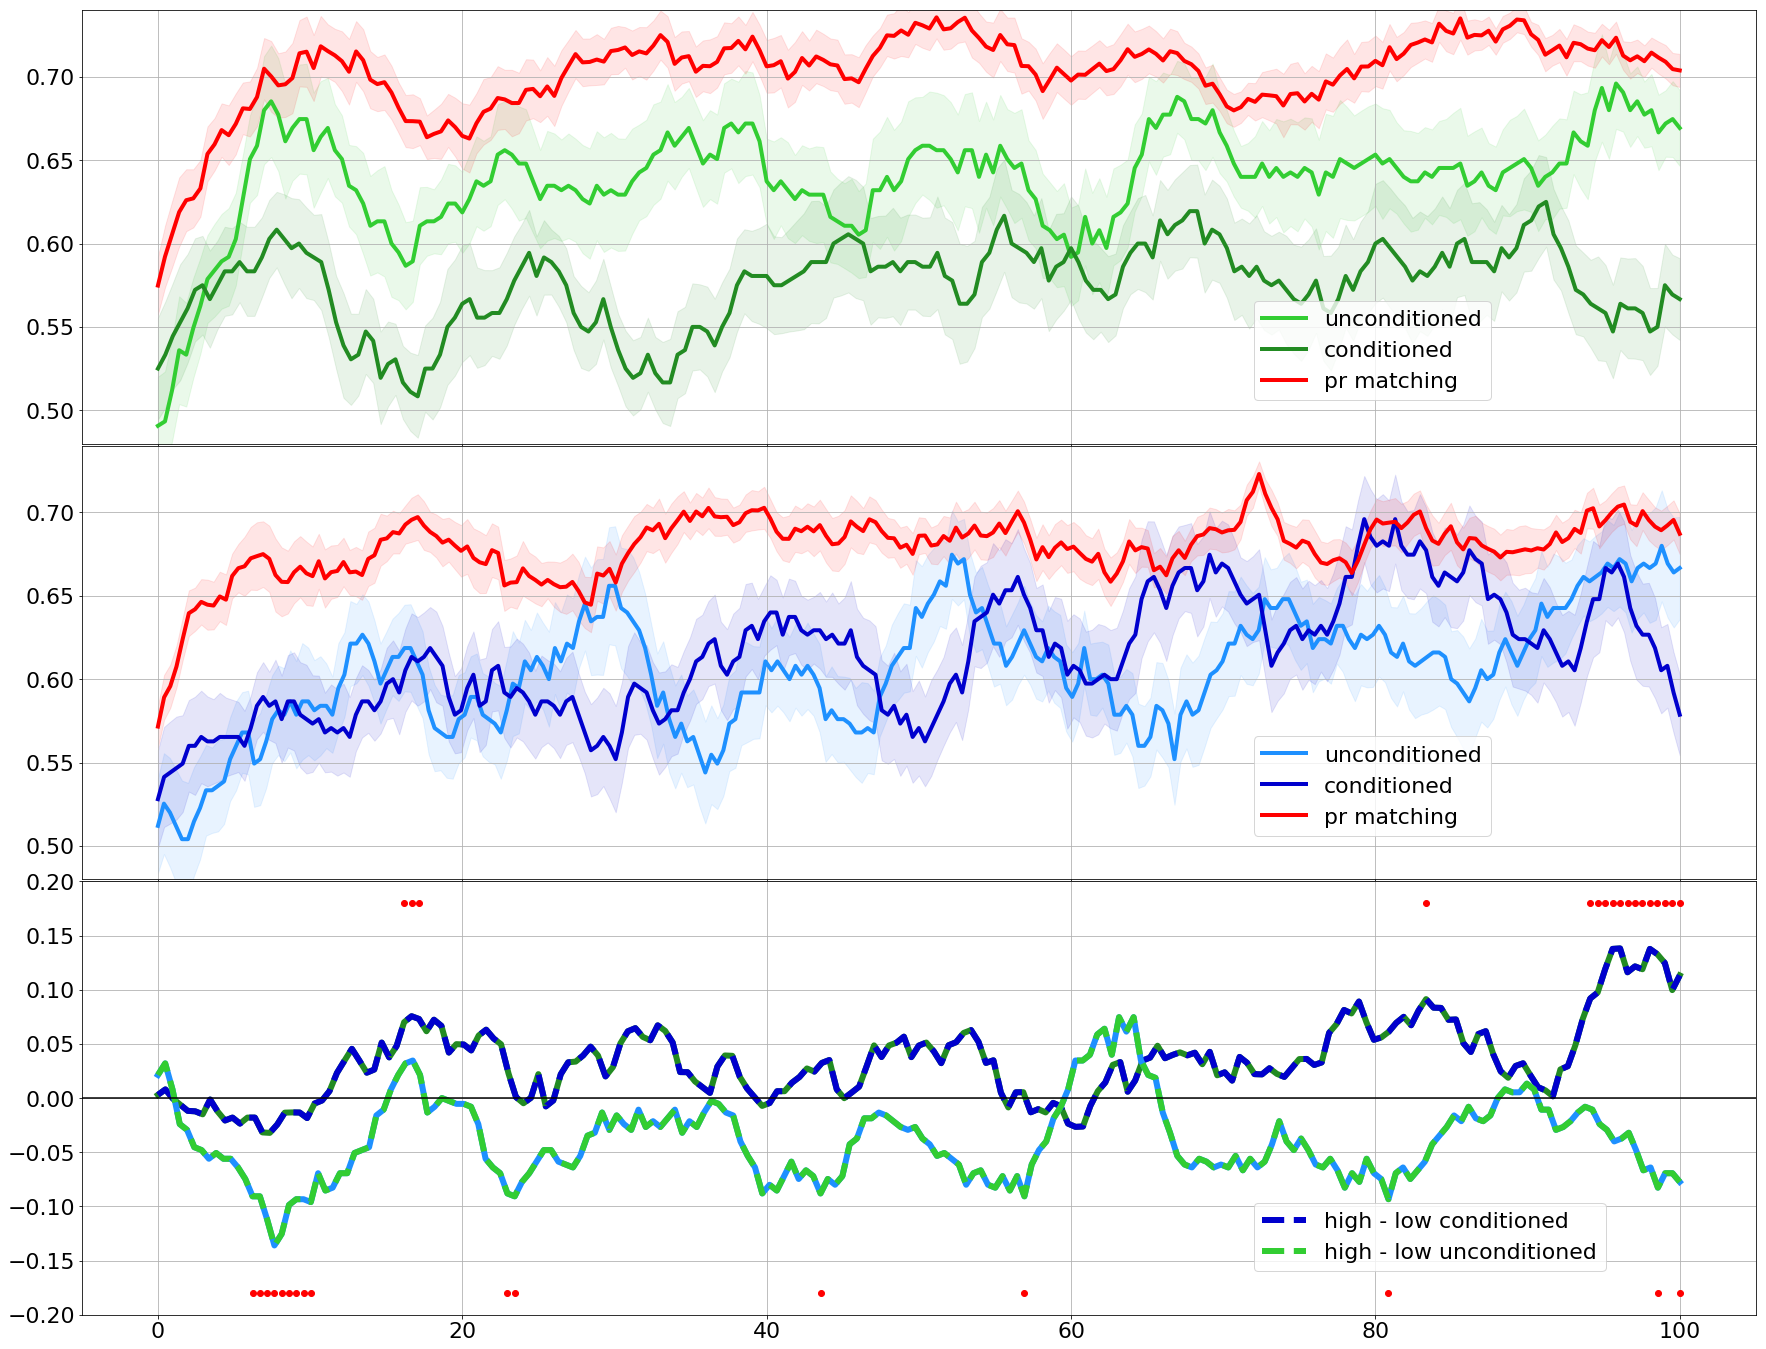

In [11]:
fig,axarr = plt.subplots(3,1,figsize=(30,8*3));axarr = axarr.reshape(-1)

plt_group(axarr[0],mean_score0,std_score0,c='limegreen',lab='unconditioned')
plt_group(axarr[0],mean_score1,std_score1,c='forestgreen',lab='conditioned')

plt_group(axarr[1],mean_score3,std_score3,c='dodgerblue',lab='unconditioned')
plt_group(axarr[1],mean_score4,std_score4,c='mediumblue',lab='conditioned')

plt_group(axarr[0],mean_expr0,std_expr0,c='r',lab='pr matching')
plt_group(axarr[1],mean_expr4,std_expr4,c='r',lab='pr matching')

# group diff
diff_uncond = mean_score3[:210] - mean_score0[:210]
diff_cond = mean_score4[:205] - mean_score1[:205]

xplt=np.linspace(0,100,len(diff_cond))
axarr[2].plot(xplt,diff_cond,c='forestgreen',ls='-',lw=6)
axarr[2].plot(xplt,diff_cond,c='mediumblue',ls='--',lw=6,label='high - low conditioned')

for x,p in zip(xplt,p_cond):
  if p<.05:
    plt.plot(x,.18,c='r',marker='.',markersize=12)
    
xplt=np.linspace(0,100,len(diff_uncond))
axarr[2].plot(xplt,diff_uncond,c='dodgerblue',ls='-',lw=6)
axarr[2].plot(xplt,diff_uncond,c='limegreen',ls='--',lw=6,label='high - low unconditioned')

for x,p in zip(xplt,p_uncond):
  if p<.05:
    plt.plot(x,-.18,c='r',marker='.',markersize=12)
    
axarr[2].axhline(0,c='black')
axarr[2].grid(True)
axarr[2].set_ylim(-.2,.2)

for ax in axarr:
  ax.legend(loc=(.7,.1))

fig.subplots_adjust(hspace=0.005)
# plt.savefig('allgroups_final.svg',format='svg')
# plt.savefig('allgroups_final2.png',format='png')
# ax.yaxis.set_ticks(np.arange(.5,.8,.1))

## individual subj plots

In [33]:
window = 30

def plt_subj(ax,subj_fqdf,window):

  # plot
#   ax.set_title('subj_filler_score %f' % fillerQ_score,size=20)
  ax.plot(mov_avg(subj_tqdf['correct_response'],window),
          c='b',label='subject response',linewidth=10)
  ax.plot(mov_avg(subj_tqdf['expr_true_edge'],window),
          c='g',label='experienced probability',linewidth=3)

#   ax.legend(fontsize=20,loc=(0,1.12))
#   
#   ax.axhline(0.5,c='r',ls='--',alpha=.7)
#   ax.axhline(0.8,c='r',ls='--',alpha=.7)
  
#   title = "subject scores - %s_window%i"%(DATASET_NAME,window)
#   plt.suptitle(title,size=50)
      
# plt_subj_scores(30)
# subj_tqdf


In [34]:
def plt_subj(ax,subj_tqdf,window,color):
  # plot
  ax.plot(mov_avg(subj_tqdf['correct_response'],window),
          c=color,label='subject response',linewidth=6)
  ax.plot(mov_avg(subj_tqdf['expr_true_edge'],window),
          c='salmon',label='experienced probability',linewidth=3)
  
  ax.grid(True)
  ax.set_ylim(0.4,1)
  ax.axhline(0.5,c='r',ls='--',alpha=.7)
  ax.axhline(0.8,c='r',ls='--',alpha=.7)
#   ax.set_xticklabels({"fontsize":22})
  ax.xaxis.label.set_fontsize(100)
  ax.yaxis.label.set_fontsize(100)


In [37]:
def plt_subjs(subj_tqdf_L,s_L,color):
  fig,axarr = plt.subplots(3,3,figsize=(3*30,3*15),sharex=True,sharey=True)
  axarr = axarr.reshape(-1)
  fig.subplots_adjust(wspace=0.01)
  for idx,sub_num in enumerate(s_L):
    subj_tqdf = subj_tqdf_L[sub_num]
    plt_subj(axarr[idx],subj_tqdf,window=30,color=color)
    

### 2S1V

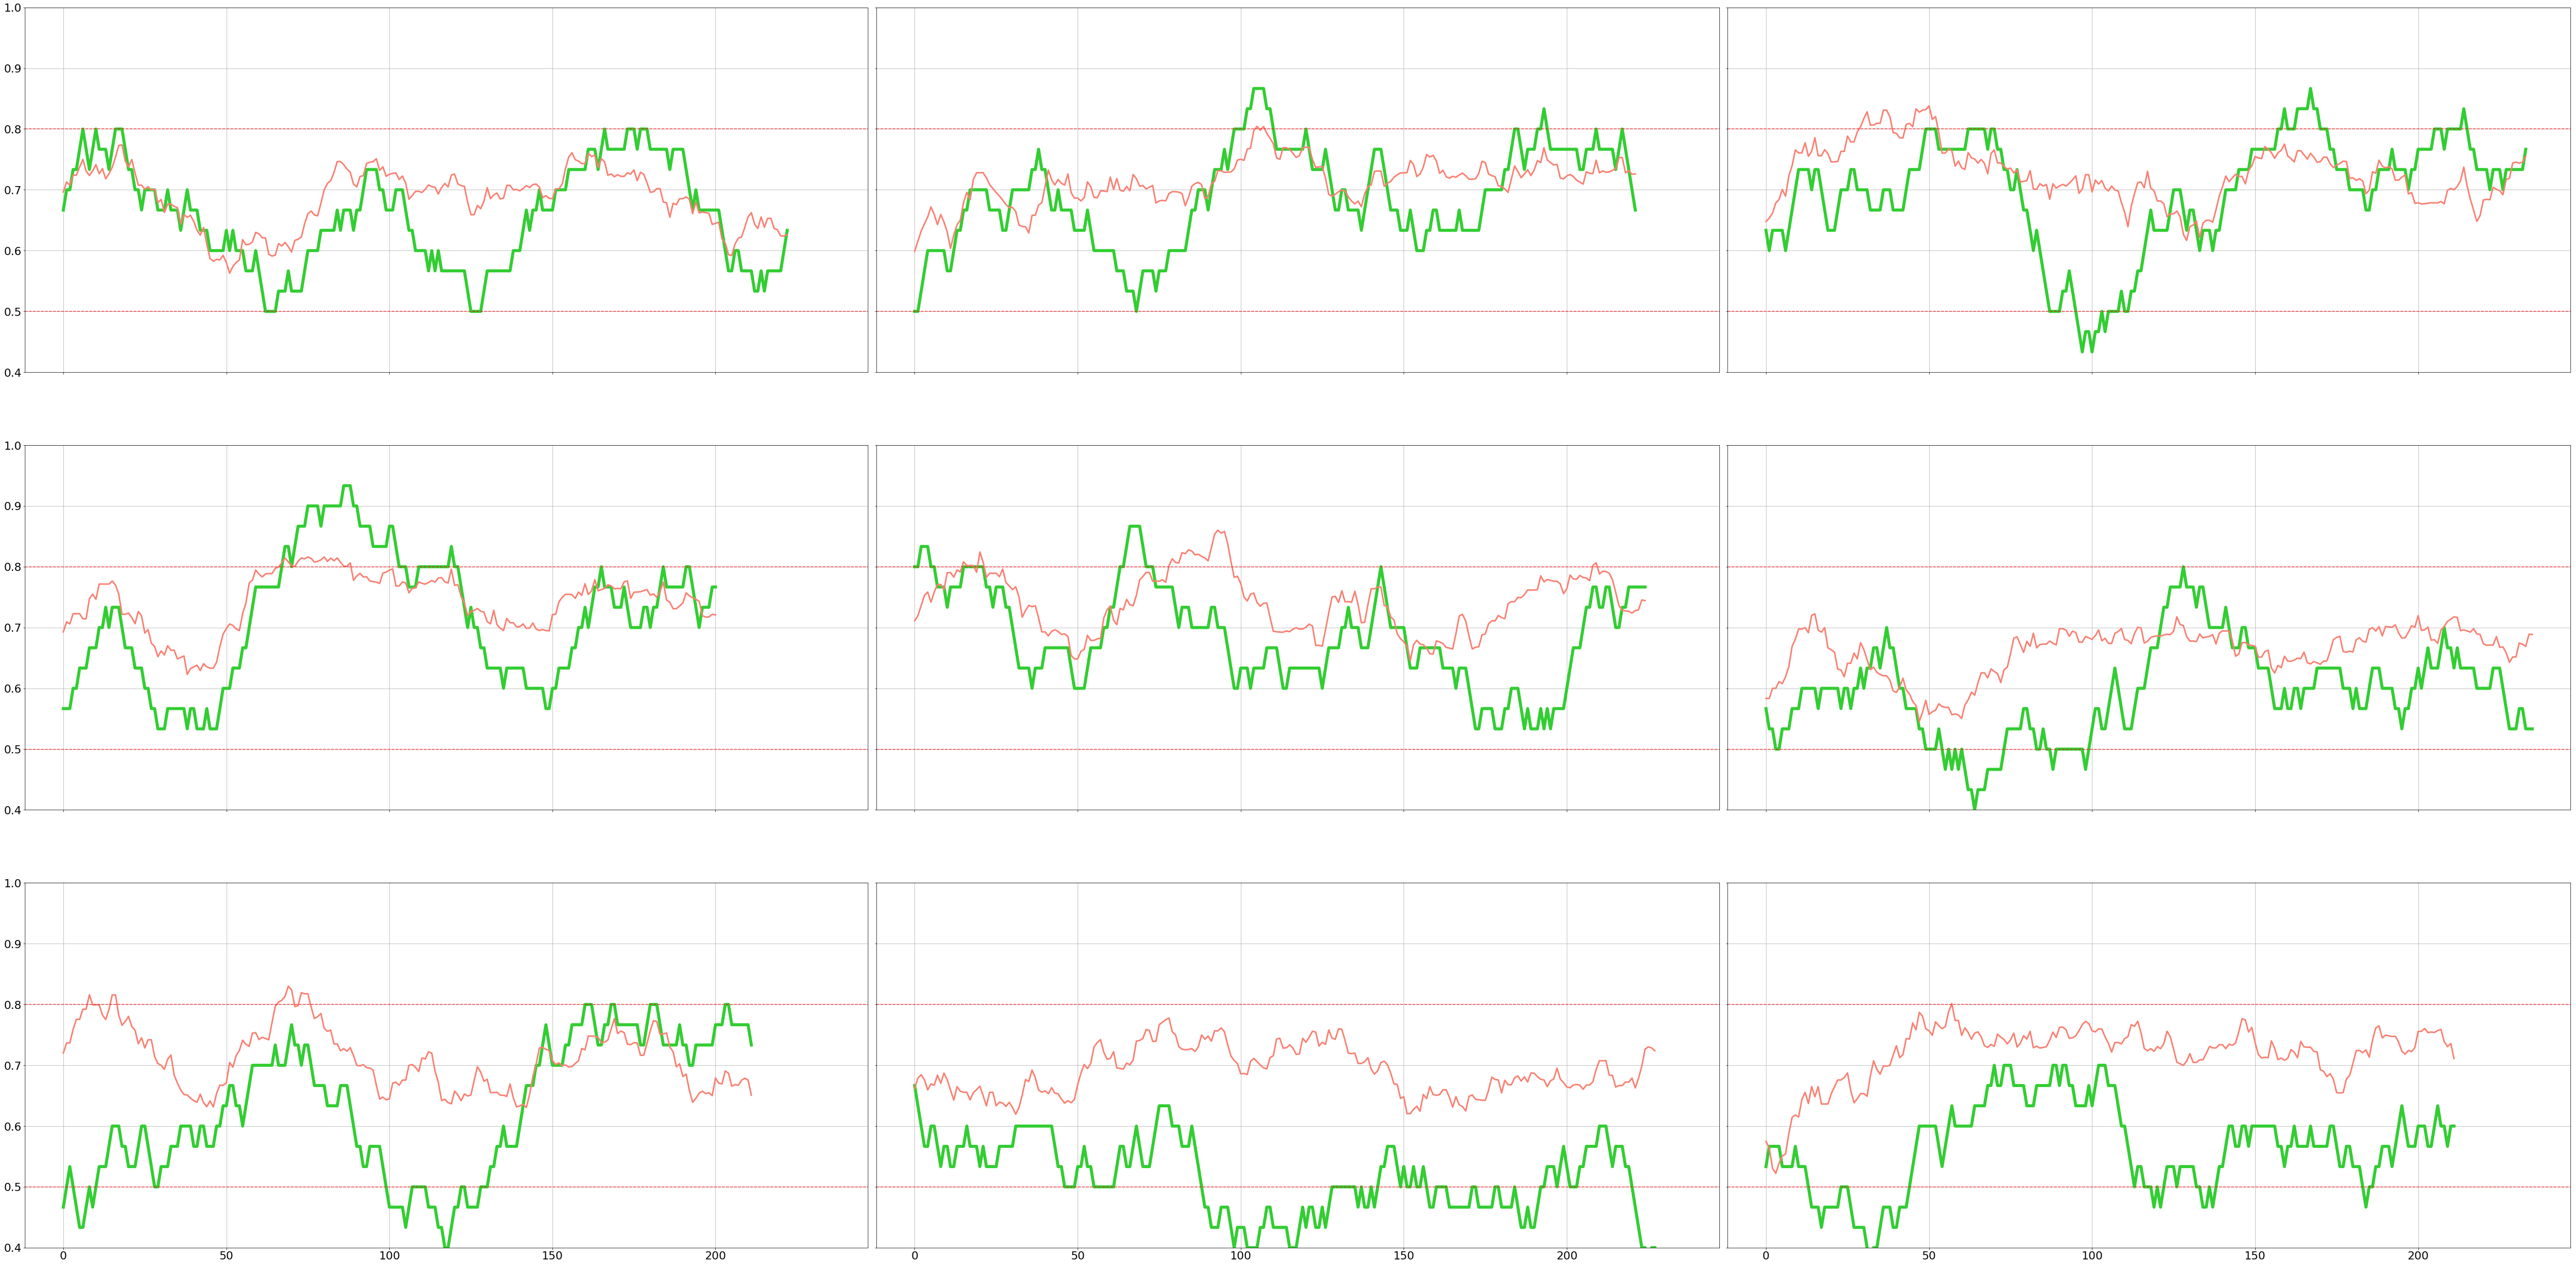

In [45]:
s_L = range(9)
plt_subjs(subj_tqdf_L0,s_L,color='limegreen')

# plt.savefig('uncond_simpRFC-subjects.png',format='png')


### richly filled

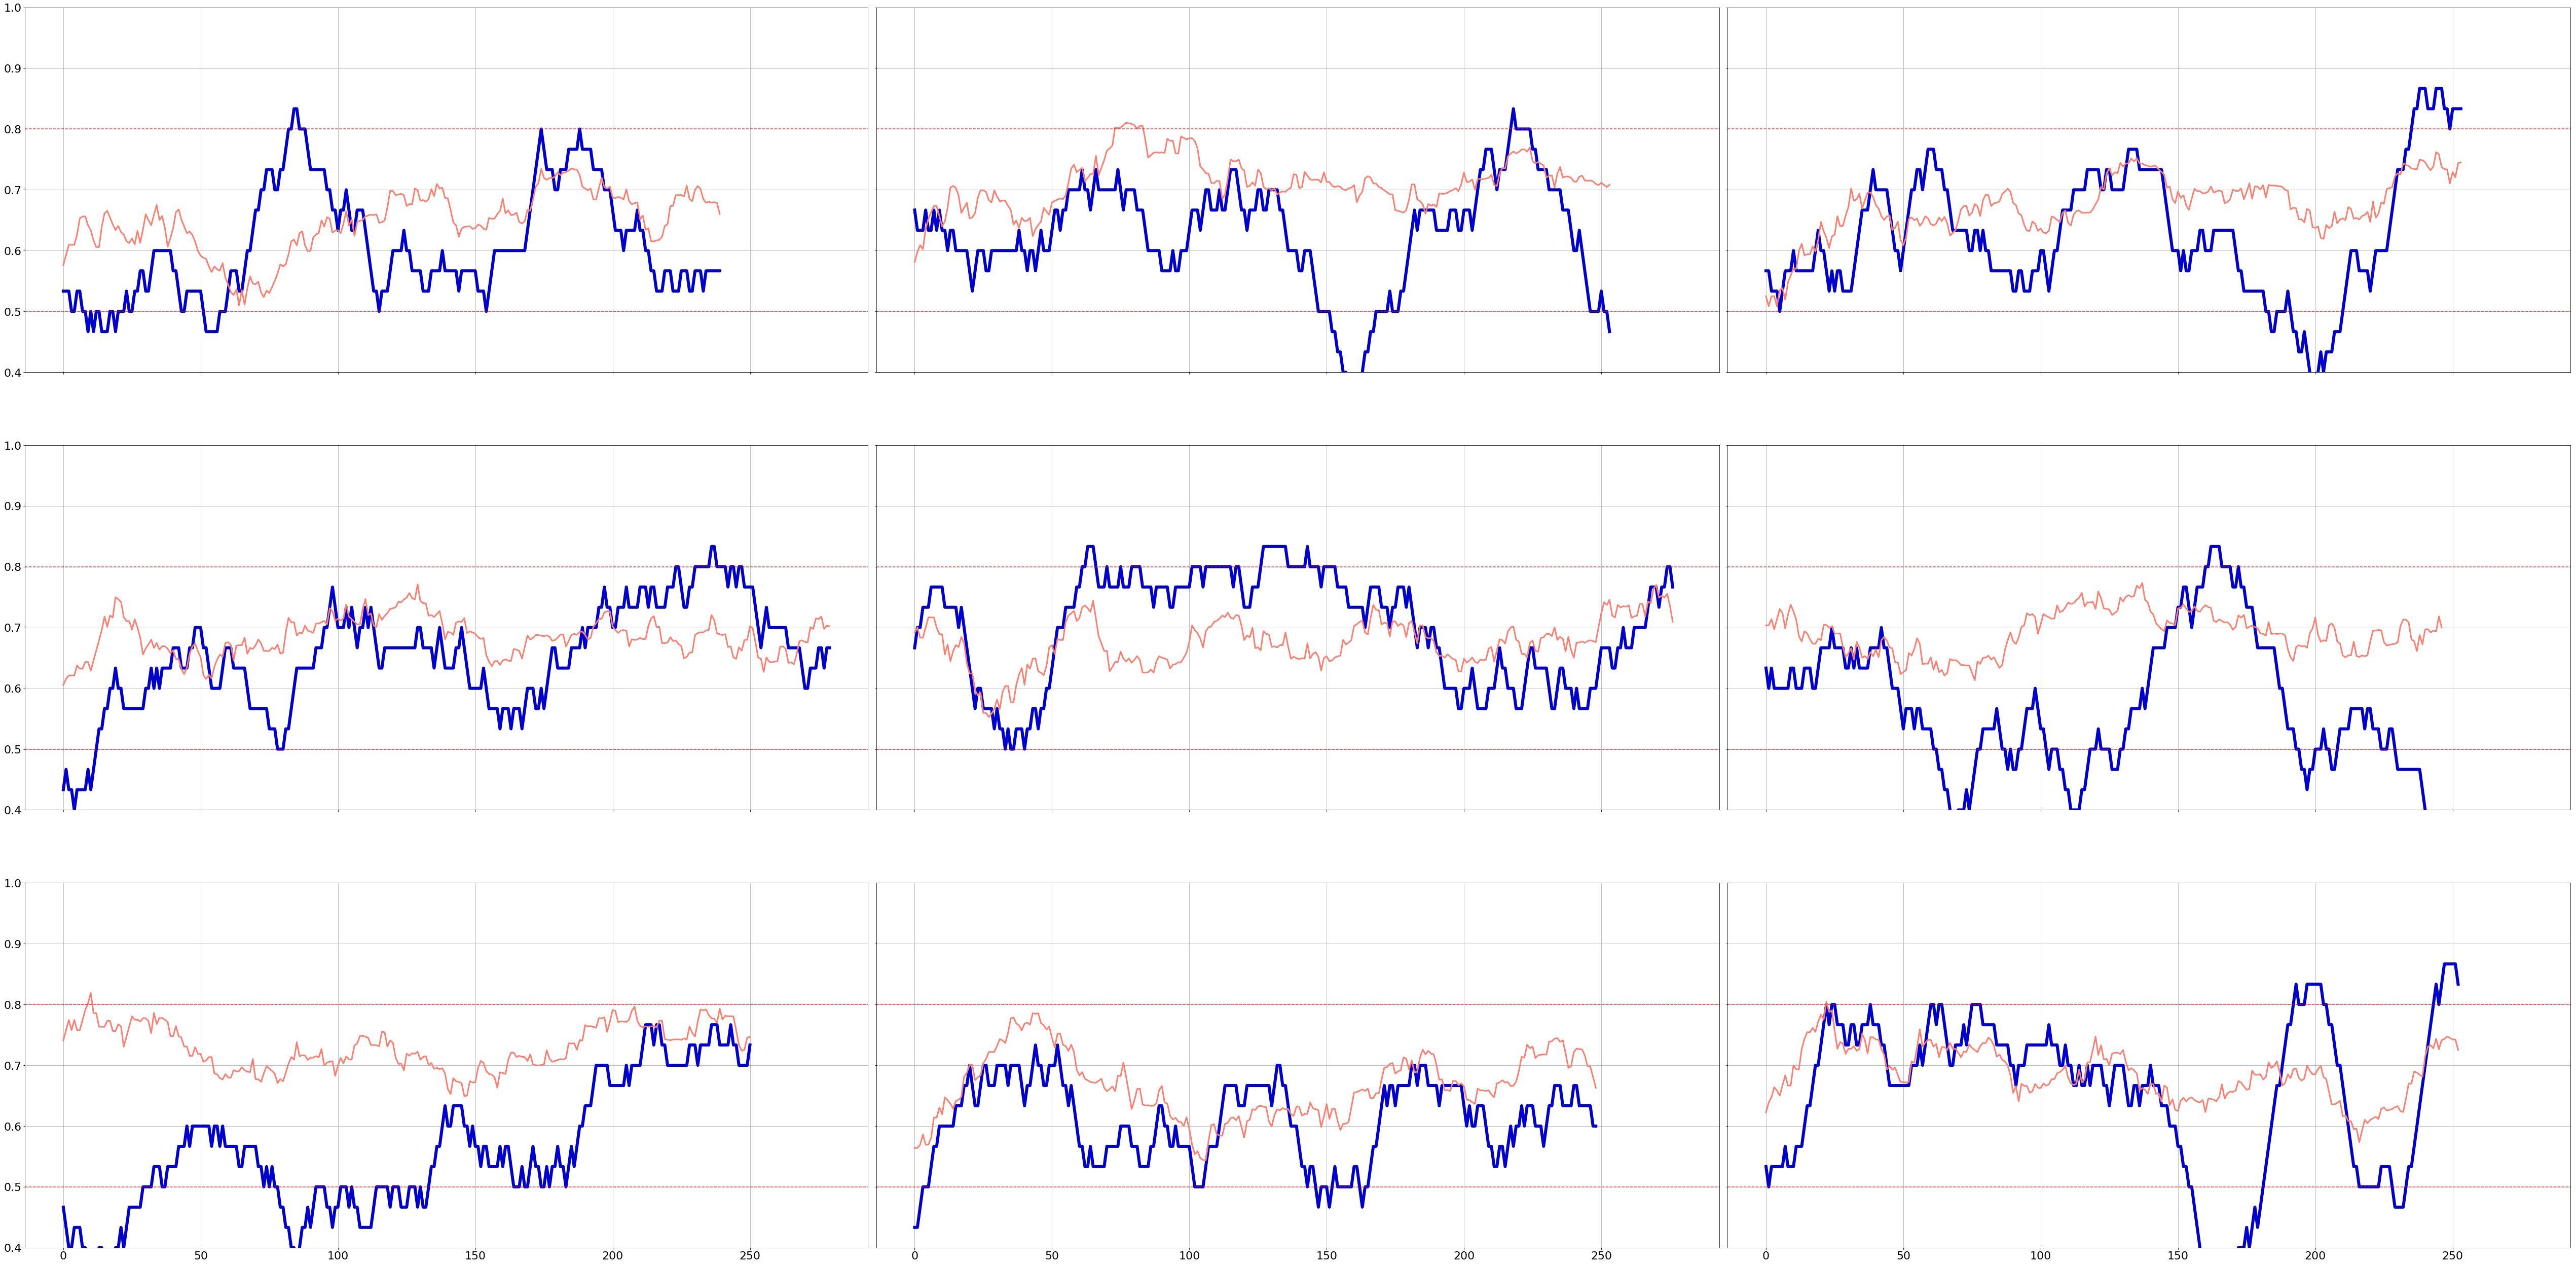

In [44]:
s_L = range(0,17,2)
plt_subjs(subj_tqdf_L3,s_L,color='mediumblue')
# plt.savefig('uncond_richRFC-subjects.png',format='png')